In [1]:
from placesCNN_amul import *

In [2]:
import os
print(os.getcwd())  # C:\Users\chung\Documents\04-Insight\insight\notebooks
os.chdir('../')
print(os.getcwd())  # C:\Users\chung\Documents\04-Insight\insight

pkl_list = load_pkl_paths('notebooks/data')
input_dataset = ImageDataset('notebooks/data')
bs = 100
image_loader = torch.utils.data.DataLoader(input_dataset, batch_size=bs)
model = load_pretrained_model()

C:\Users\chung\Documents\04-Insight\insight\notebooks
C:\Users\chung\Documents\04-Insight\insight


In [3]:
from time import time

In [4]:
start = time()
annoy_idx = getVectorIndex(model, image_loader)
end = time()

In [5]:
print('Indices generated in %.2fs.'%(end-start)) #257sec for 2529 images

Indices generated in 294.65s.


In [6]:
def get_similar(item_no, annoyIndex):
    """ Query similar images based on index of existing 
    images in the database
    Arguments:
        item_no -- index of the image to be used for querying 
        annoyIndex -- pre-built Annoy Index
    Returns:
        [indices] -- 5 nearest neighbor indices for query image
    """
#     results = annoyIndex.get_nns_by_item(item_no, 5, include_distances=True)
#     return [[a, results[1][i]] for i, a in enumerate(results[0])]
    return annoyIndex.get_nns_by_item(item_no, 5, include_distances=False)

In [7]:
print(get_similar(123,annoy_idx))

[123, 1384, 124, 690, 125]


In [8]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

def plots(indices, pd, figsize=(12,6), rows=1, titles=None, title=None):
    """
    Custom plot function to summarize the reverse image search results 
    """
    f = plt.figure(figsize=figsize)
    plt.subplots_adjust(left=0.1, bottom=0, right=0.2, top=1.02, wspace=0.02, hspace=0.02)
    plt.axis('Off')
    cols = len(indices)//rows if len(indices) % rows == 0 else len(indices)//rows + 1
    for i, img_idx in enumerate(indices):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        sp.get_xaxis().set_visible(False)
        sp.get_yaxis().set_visible(False)
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        data = Image.open(pd.iloc[img_idx].path, 'r')
        data = data.convert('RGB')
        data = data.resize((400,200), Image.ANTIALIAS)
        plt.imshow(data)
        plt.tight_layout()
    plt.autoscale(tight=True)
    if title is not None:
        plt.suptitle(title, size=32)
        f.tight_layout()
        f.subplots_adjust(top=0.94)
        plt.show()
        
def plot_similar(indices, annoyIndex, pd):
    nn_output = [get_similar(i, annoyIndex) for i in indices ]
    flat_list = np.asarray(nn_output).transpose().reshape(-1).tolist()
    plots(flat_list, pd, figsize=(26,22), rows=5)

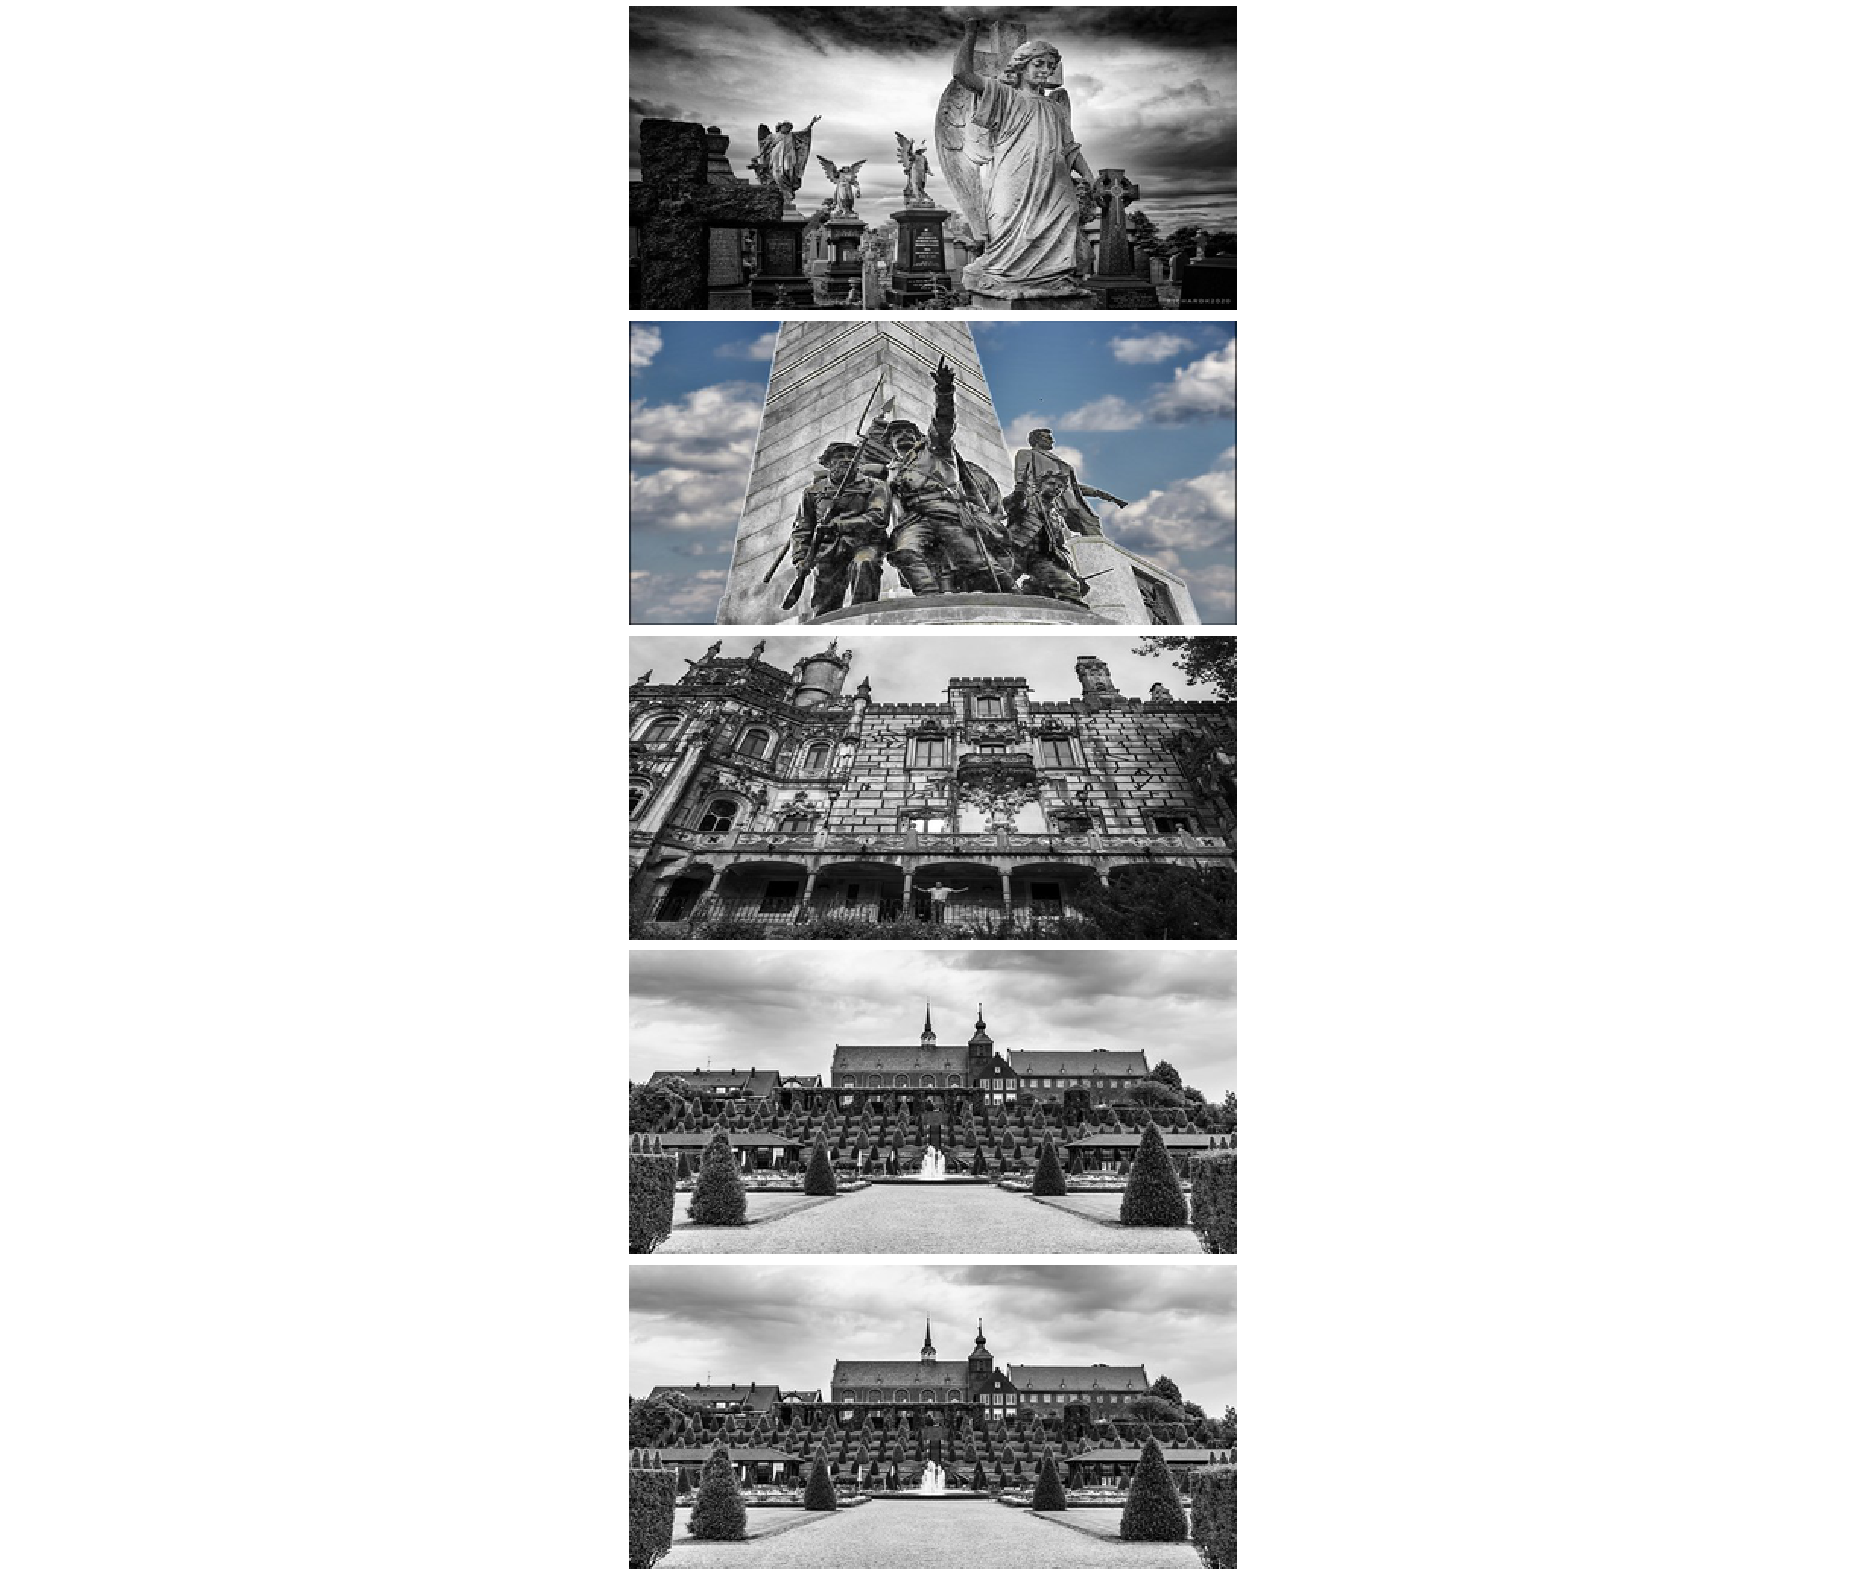

In [9]:
pd_files = input_dataset.get_file_df()
plot_similar([429], annoy_idx, pd_files)

In [10]:
import sys
sys.getsizeof(annoy_idx) #32 bytes

32

In [11]:
sys.getsizeof(pd_files) #pd_files is ~400MB

798478

In [97]:
sim = get_similar(325,annoy_idx)
print(sim)

[325, 1045, 2055, 2303, 685]


In [98]:
#for the 1st index, read pd_files for the class label
class_labels = list(pd_files.iloc[sim].label.drop_duplicates())
print(class_labels)

['butte', 'highway', 'ski slope', 'tree farm', 'desert']


In [99]:
name = list(pd_files.iloc[sim]['name'].str.rstrip('.jpg'))
print(name)

['34792135963', '49932424151', '49921641532', '32367656337', '49816575847']


In [100]:
import pickle
for_plotly = pd.DataFrame(columns=['latitude','longitude'])
for label in class_labels:
    with open('notebooks/data/%s/%s.pkl'%(label,label), 'rb') as f:
        locations = pickle.load(f)
        for_plotly = pd.concat([locations.loc[locations['id'].isin(name)][['latitude','longitude']],for_plotly])
        f.close()
print(for_plotly)

     latitude    longitude
11  48.216579    11.589436
11  43.415507   -72.329585
0   59.348705    16.513717
0   48.469065   -81.422359
7   45.546860  -122.566298


In [101]:
import plotly.express as px
fig = px.scatter_geo(for_map, lat='latitude', lon='longitude')
fig.show()

In [135]:
transform = trn.Compose([trn.Resize((256, 256)),
                               trn.CenterCrop(224),
                               trn.ToTensor(),
                               trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                              ])

def evalTestImage(test_img, model, annoy_index, top_n=5):
    '''
    Search for the closest image as the test iamge.
    :param test_img: path of test image
    :param model:
    :param annoy_index:
    :return:
    '''
    with torch.no_grad():
        model.eval()
        data = Image.open(test_img,'r').convert('RGB')
        data = transform(data).unsqueeze(0)
#         img_loader = DataLoader(data)
#         for idx, img in enumerate(img_loader):
        feature = model(data)
    searches = annoy_index.get_nns_by_vector(feature[0], top_n, include_distances=False)
    return searches

In [136]:
test_img = 'notebooks/47082050801.jpg'
searches = evalTestImage(test_img, model, annoy_idx)

In [143]:
searches

[2056, 867, 1773, 870, 1597]

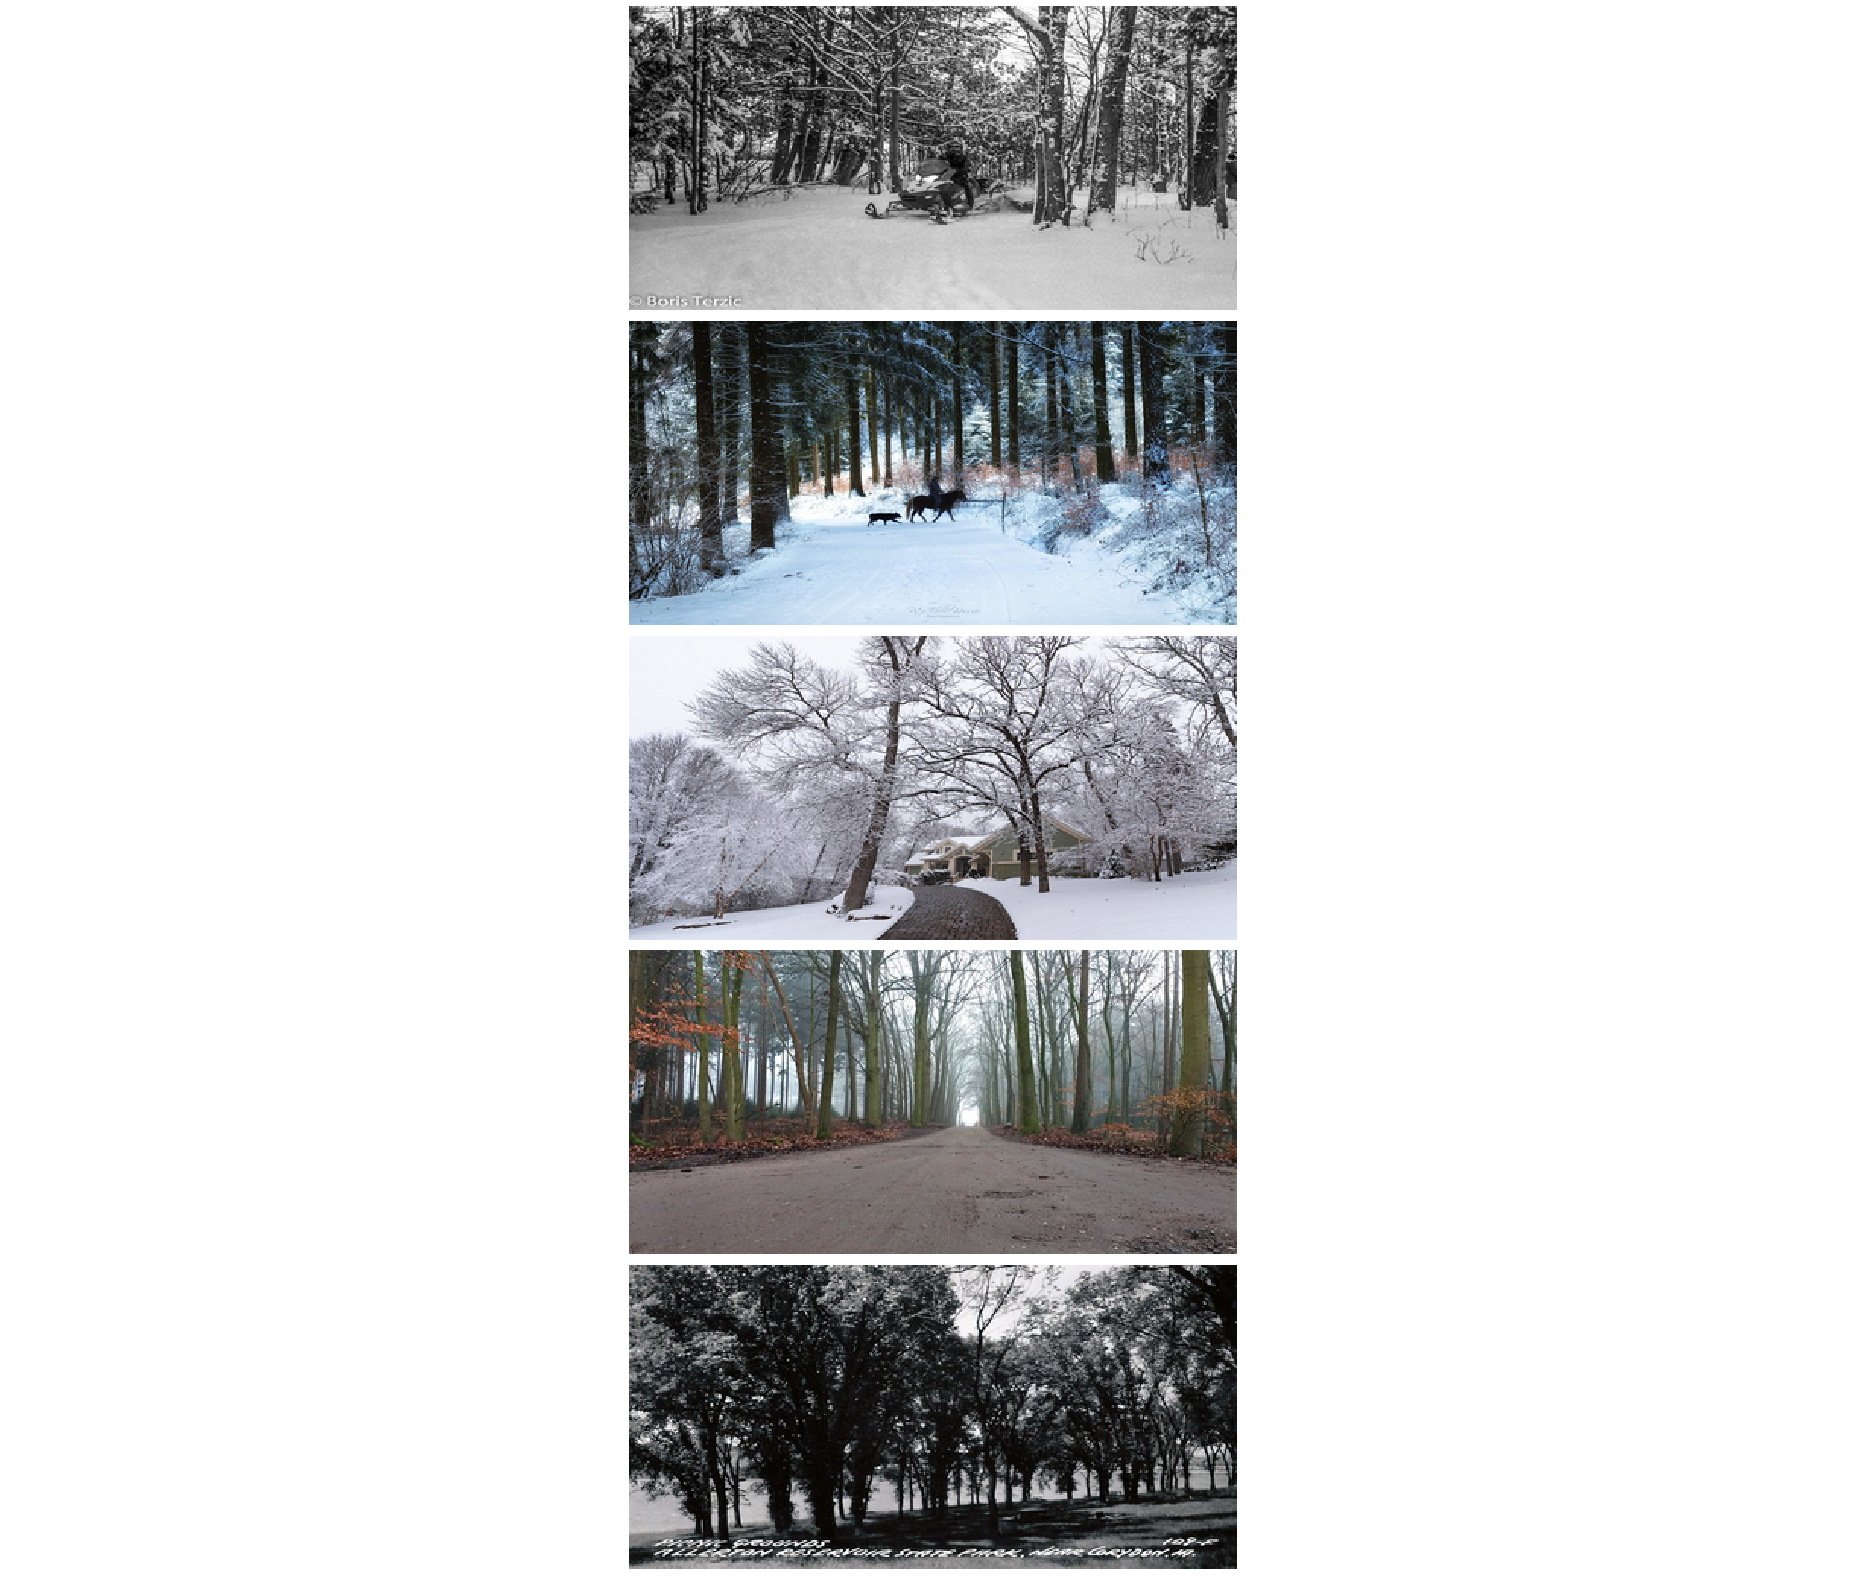

In [144]:
plot_similar([searches[0]], annoy_idx, pd_files)